In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from datetime import timedelta

In [2]:
# Load data and sort them by time
df = pd.read_csv("./Data/traffic.csv")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.sort_values(by=['DateTime'], inplace=True)

In [3]:
# Encode Junction as a numerical feature
junction_encoder = LabelEncoder()
df['Junction_encoded'] = junction_encoder.fit_transform(df['Junction'])

In [4]:
# Extract time-based features for better pattern recognization
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['Month'] = df['DateTime'].dt.month
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

In [5]:
# Normalize data

scaler_dict = {}
numerical_features = ['Vehicles', 'Hour', 'DayOfWeek', 'Month', 'Junction_encoded']
for feature in numerical_features:
    scaler = MinMaxScaler()
    df[f'{feature}_normalized'] = scaler.fit_transform(df[[feature]])
    scaler_dict[feature] = scaler

In [6]:
# LSTM model with multi-step prediction
class JunctionTrafficLSTM(nn.Module):
    def __init__(self, input_size=5, hidden_size=32, num_layers=5, output_size=1):
        super(JunctionTrafficLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x, future_steps=1, teacher_forcing_ratio=0.5):
        batch_size = x.size(0)
        outputs = []
        lstm_out, (h, c) = self.lstm(x)
        decoder_input = x[:, -1:, :]
        
        for i in range(future_steps):
            # Run LSTM step
            out, (h, c) = self.lstm(decoder_input, (h, c))
            
            # Process through
            features = self.dropout(out[:, -1])
            features = self.relu(self.fc1(features))
            features = self.relu(self.fc2(features))
            prediction = self.fc3(features)
            
            outputs.append(prediction)
        
            if self.training and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input = x[:, i+1:i+2, :] if i+1 < x.size(1) else decoder_input
            else:
                next_input = decoder_input.clone()
                next_input[:, 0, 0] = prediction.squeeze()
                decoder_input = next_input
        
        return torch.stack(outputs, dim=1)

In [7]:
def create_multistep_sequences(data, input_seq_length, prediction_length):
    feature_cols = [col for col in data.columns if '_normalized' in col]
    sequences = []
    targets = []
    
    # Group by junction to ensure sequences don't cross junction boundaries
    for junction in data['Junction'].unique():
        junction_data = data[data['Junction'] == junction].copy()
        
        for i in range(len(junction_data) - input_seq_length - prediction_length):
            seq = junction_data[feature_cols].iloc[i:i+input_seq_length].values
            target = junction_data['Vehicles_normalized'].iloc[i+input_seq_length:i+input_seq_length+prediction_length].values
            
            sequences.append(seq)
            targets.append(target)
    
    return np.array(sequences), np.array(targets)

In [8]:
def train_multistep_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=10, prediction_length=24):
    best_val_loss = float('inf')
    patience_counter = 0
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            
            # Generate predictions
            outputs = model(batch_X, future_steps=prediction_length)
            
            # Ensure outputs and batch_y have the same shape
            outputs = outputs.squeeze()
            if len(outputs.shape) == 1:
                outputs = outputs.unsqueeze(0)
            if len(batch_y.shape) == 1:
                batch_y = batch_y.unsqueeze(0)

            loss = criterion(outputs, batch_y)

            if outputs.size(1) > 1:
                output_diff = outputs[:, 1:] - outputs[:, :-1]
                target_diff = batch_y[:, 1:] - batch_y[:, :-1]
                
                min_length = min(output_diff.size(1), target_diff.size(1))
                consistency_loss = criterion(
                    output_diff[:, :min_length],
                    target_diff[:, :min_length]
                )
                loss = loss + 0.1 * consistency_loss
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X, future_steps=prediction_length)
                
                outputs = outputs.squeeze()
                if len(outputs.shape) == 1:
                    outputs = outputs.unsqueeze(0)
                if len(batch_y.shape) == 1:
                    batch_y = batch_y.unsqueeze(0)
                    
                val_loss += criterion(outputs, batch_y).item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

In [9]:
def accuracy(model, test_loader, threshold, prediction_length=24):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X, future_steps=prediction_length)
            difference = torch.abs(outputs.squeeze() - batch_y)
            correct += (difference <= threshold).sum().item()
            total += batch_y.numel()
    
    accuracy_percentage = (correct / total) * 100
    print(f"Test Accuracy: {accuracy_percentage:.2f}%")
    return accuracy_percentage

In [10]:
def predict_future_traffic(model, latest_time, num_hours, scalers, junction, seq_length=10):
    """
    Make predictions for a specific junction
    
    Parameters:
    - model: trained LSTM model
    - latest_time: datetime object for the starting point
    - num_hours: number of time steps to predict
    - scalers: dictionary of fitted scalers
    - junction: junction identifier (either number or string)
    - seq_length: length of input sequence
    
    Returns:
    - numpy array of predictions
    """
    model.eval()
    
    # Convert junction to integer if it's a string
    if isinstance(junction, str) and junction.isdigit():
        junction = int(junction)
    
    # Filter data for specific junction
    junction_data = df[df['Junction'] == junction].copy()
    
    if len(junction_data) <seq_length:
        raise ValueError(f"Not enough data points for junction {junction}. Need at least {seq_length} points.")
    
    # Reset index for the filtered data to avoid indexing issues
    junction_data = junction_data.reset_index(drop=True)
    
    # Find the closest time in our data to the requested time
    closest_time_idx = (junction_data['DateTime'] - latest_time).abs().argmin()
    
    # Check if we have enough data points after the closest time
    if closest_time_idx + seq_length > len(junction_data):
        # If not enough points after, we need to use earlier data
        closest_time_idx = len(junction_data) - seq_length
    
    time_diff = junction_data.iloc[closest_time_idx]['DateTime'] - latest_time
    print(f"Time difference from requested: {time_diff}")
    
    # Get feature columns and input sequence
    feature_cols = [col for col in df.columns if '_normalized' in col]
    input_seq = junction_data.iloc[closest_time_idx:closest_time_idx+seq_length][feature_cols].values
    
    # Convert to tensor and make prediction
    input_seq = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
    
    with torch.no_grad():
        predictions = model(input_seq, future_steps=num_hours)
        predictions = predictions.squeeze().cpu().numpy()
    
    # Inverse transform to get actual vehicle numbers
    predictions = scalers['Vehicles'].inverse_transform(predictions.reshape(-1, 1)).flatten()
    
    return predictions

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seq_length = 10
prediction_length = 24  # 24 hours ahead

In [12]:
X, y = create_multistep_sequences(df, seq_length, prediction_length)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

val_size = int(0.1 * len(X_train))
X_val = X_train[-val_size:]
y_val = y_train[-val_size:]
X_train = X_train[:-val_size]
y_train = y_train[:-val_size]

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

In [13]:
model = JunctionTrafficLSTM().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#train_multistep_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=10, prediction_length=prediction_length)

Epoch 1, Train Loss: 0.0052, Val Loss: 0.0038
Epoch 2, Train Loss: 0.0019, Val Loss: 0.0025
Epoch 3, Train Loss: 0.0013, Val Loss: 0.0023
Epoch 4, Train Loss: 0.0011, Val Loss: 0.0024
Epoch 5, Train Loss: 0.0010, Val Loss: 0.0024
Epoch 6, Train Loss: 0.0010, Val Loss: 0.0022
Epoch 7, Train Loss: 0.0009, Val Loss: 0.0021
Epoch 8, Train Loss: 0.0009, Val Loss: 0.0021
Epoch 9, Train Loss: 0.0008, Val Loss: 0.0021
Epoch 10, Train Loss: 0.0008, Val Loss: 0.0020
Epoch 11, Train Loss: 0.0008, Val Loss: 0.0023
Epoch 12, Train Loss: 0.0007, Val Loss: 0.0021
Epoch 13, Train Loss: 0.0007, Val Loss: 0.0022
Epoch 14, Train Loss: 0.0007, Val Loss: 0.0020
Epoch 15, Train Loss: 0.0006, Val Loss: 0.0020
Epoch 16, Train Loss: 0.0006, Val Loss: 0.0021
Epoch 17, Train Loss: 0.0006, Val Loss: 0.0020
Epoch 18, Train Loss: 0.0006, Val Loss: 0.0020
Epoch 19, Train Loss: 0.0006, Val Loss: 0.0020
Epoch 20, Train Loss: 0.0006, Val Loss: 0.0019
Epoch 21, Train Loss: 0.0006, Val Loss: 0.0020
Epoch 22, Train Loss: 

In [22]:
latest_time = pd.to_datetime("2016-11-03 07:00:00")
junction = 1
count = 3

# Load best model
model.load_state_dict(torch.load('best_saved_model.pth'))
try:
    predictions = predict_future_traffic(model, latest_time, count, scaler_dict, junction)
    
    # Change timedelta for different prediction interval
    predicted_times = [latest_time + 100* timedelta(days=i) for i in range(count)]
    predicted_traffic_df = pd.DataFrame({
        'Predicted Time': predicted_times,
        'Predicted Traffic (Vehicles)': (predictions)//1,
        'Junction': junction
    })
    
    print(predicted_traffic_df)
    predicted_traffic_df.to_csv('predicted_traffic.csv', index=False)
except ValueError as e:
    print(f"Error: {e}")
    # Let's also print the first few rows of the DataFrame to see what it looks like
    print("\nFirst few rows of the DataFrame:")
    print(df[['Junction', 'DateTime', 'Vehicles']].head(10))

Time difference from requested: 0 days 00:00:00
       Predicted Time  Predicted Traffic (Vehicles)  Junction
0 2016-11-03 07:00:00                          65.0         1
1 2017-02-11 07:00:00                          67.0         1
2 2017-05-22 07:00:00                          70.0         1



Accuracy for 24-hour predictions:
Threshold: 0.030 (5 vehicles)
Accuracy: 56.12%

Accuracy for 48-hour predictions:
Threshold: 0.030 (5 vehicles)
Accuracy: 56.12%

Accuracy for 72-hour predictions:
Threshold: 0.030 (5 vehicles)
Accuracy: 56.12%


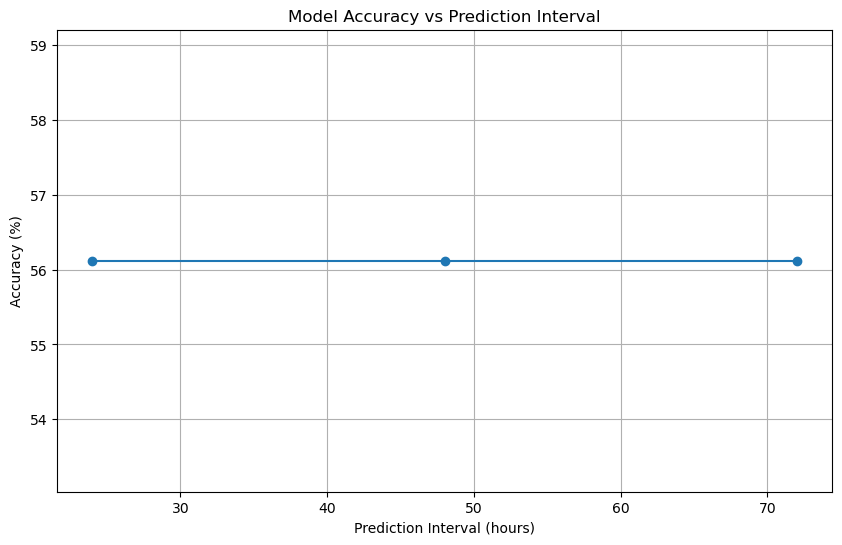

In [ ]:
def evaluate_accuracy_by_interval(model, test_loader, threshold, intervals):
    """
    Evaluate model accuracy for different prediction intervals
    
    Parameters:
    - model: trained LSTM model
    - test_loader: DataLoader containing test data
    - threshold: threshold for considering a prediction correct
    - intervals: list of hour intervals to evaluate
    
    Returns:
    - Dictionary of accuracies for each interval
    """
    model.eval()
    results = {}
    
    for interval in intervals:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                # Get predictions for current interval
                outputs = model(batch_X, future_steps=interval)

                outputs = outputs.squeeze(-1)
                

################################################################################
                # Ensure batch_y has enough steps; use available data
                actual_interval = min(interval, batch_y.shape[1])
                outputs = outputs[:, :actual_interval]
                batch_y = batch_y[:, :actual_interval]
################################################################################

                
                # Calculate accuracy
                difference = torch.abs(outputs.squeeze() - batch_y)
                correct += (difference <= threshold).sum().item()
                total += batch_y.numel()
        
        accuracy_percentage = (correct / total) * 100
        results[interval] = accuracy_percentage
        
        # Convert threshold to actual vehicle numbers for interpretation
        uncertainty = (scaler_dict['Vehicles'].inverse_transform([[threshold]]) - 
                      scaler_dict['Vehicles'].inverse_transform([[0]]))[0][0]
        
        print(f"\nAccuracy for {interval}-hour predictions:")
        print(f"Threshold: {threshold:.3f} ({int(uncertainty)} vehicles)")
        print(f"Accuracy: {accuracy_percentage:.2f}%")
    
    return results

# Example usage:
threshold = 0.03  # You can adjust this threshold
intervals_to_test = [24, 48, 72]  # You can modify these intervals

#######################
# problem in predicting with different intervals, 
# also missing functionality to be able to predict traffic at different junctions
#######################
# Run evaluation
accuracy_results = evaluate_accuracy_by_interval(
    model=model,
    test_loader=test_loader,
    threshold=threshold,
    intervals=intervals_to_test
)

# Plot results if desired
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(list(accuracy_results.keys()), list(accuracy_results.values()), marker='o')
plt.xlabel('Prediction Interval (hours)')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy vs Prediction Interval')
plt.grid(True)
plt.show()